# Frailty Risk Modeling v3 (using DE genes)
### Author: Shehbeel Arif
### Purpose: To develop an ML or statistical model to determine a patient's frailty risk status based on the muscle gene expression data.

---

## Load libraries

In [43]:
# Libraries for data handling
import numpy as np
import pandas as pd

# Data preprocessing
from sklearn.preprocessing import LabelEncoder

# Library for splitting data into Training and Testing datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Import Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


# Import sklearn package to assess model accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from statistics import mean, stdev


# Library for visualizations
from umap.umap_ import UMAP # ! pip install umap-learn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Preprocessing

In [44]:
# Load data
meta = pd.read_csv('/Users/shehbeel/Documents/frailty-clinical-model/data/GSE144304_meta.txt', delimiter='\t')
counts = pd.read_csv('/Users/shehbeel/Documents/frailty-clinical-model/analyses/01-convert-ensembl-ids/results/GSE144304_raw_counts_with_genes.csv', index_col='gene_symbol')
de_df = pd.read_csv('/Users/shehbeel/Documents/frailty-clinical-model/analyses/04-de-analysis/results/FrailvAll_DEG_mrna.csv')

# Transpose counts
counts = counts.T

# Select DE genes that have LFC < -1 or LFC > 1 and p<0.05
de_df = de_df[de_df['pvalue'] < 0.05]
de_df = de_df[de_df['log2FoldChange'].abs() > 1]
de_genes = de_df['Gene']

filtered_counts = counts[de_genes]
filtered_counts = filtered_counts.reset_index()

# Merge counts and meta data
df = pd.merge(meta, filtered_counts, left_on='sample_id', right_on='index').drop(['index'], axis=1)
df

# Encode Gender
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

# Drop sample_id, frailty columns
df = df.drop(['sample_id', 'condition'], axis=1)
df

,gender,frailty,ITLN1,LEP,PEX5L,LINC02660,MAL2,KLB,EGFL6,MRAP,...,NPR3,GBP6,NPAS4,WFDC21P,XCR1,CRADD-AS1,IGFN1,AHRR,OPRD1,CYP1A1
0,1,1,29,366,0,0,30,106,411,17,...,72,0,0,0,0,0,35,2,0,0
1,1,1,2,66,1,0,1,6,4,4,...,25,0,0,0,1,0,888,2,2,1
2,1,1,0,77,2,1,8,11,12,6,...,28,0,0,0,0,0,55,4,5,8
3,1,1,0,4,7,4,2,1,1,1,...,11,0,0,0,0,0,172,1,0,6
4,1,1,0,2,0,1,0,1,0,1,...,36,0,0,1,0,0,1048,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,0,0,3,0,0,0,0,0,0,...,58,2,2,0,0,0,2028,2,3,73
76,1,0,0,1,0,0,0,1,0,0,...,424,0,0,1,0,2,14595,2,21,116
77,1,0,0,0,1,0,0,0,2,1,...,18,10,5,0,0,0,551,0,3,1
78,1,0,0,0,1,0,0,0,0,1,...,96,1,0,0,1,0,7005,0,0,0


## Split into Training and Testing set

In [45]:
# Split the dataset into training data and labels
X = df.loc[:, df.columns != 'frailty']
# X = X.iloc[:,1:]
y = df.loc[:, df.columns == 'frailty'].values.ravel()

# Sanity check
#print(X[:5])
#print(y[:5])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

#Sanity check
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(64, 224) (16, 224) (64,) (16,)


---

## Visualize the data

<Axes: xlabel='0', ylabel='1'>

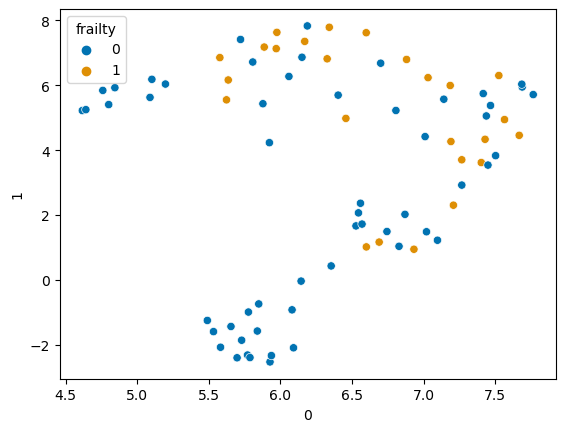

In [46]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.iloc[:,2:])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.frailty, palette="colorblind")

---

## Build Baseline Model (Random Forest)

In [48]:
# Instantiate the Random Forest Classifier
rfc = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the classifier to data
rfc.fit(X_train, y_train)

# Predict on test dataset
y_pred = rfc.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(rfc.predict_proba(X_test))
print(y_test)

Accuracy: 0.75
[[0.46501331 0.53498669]
 [0.70785923 0.29214077]
 [0.770149   0.229851  ]
 [0.96621457 0.03378543]
 [0.30041057 0.69958943]
 [0.89383287 0.10616713]
 [0.56694709 0.43305291]
 [0.92568347 0.07431653]
 [0.96373553 0.03626447]
 [0.6401274  0.3598726 ]
 [0.25508479 0.74491521]
 [0.82307657 0.17692343]
 [0.76601478 0.23398522]
 [0.5754289  0.4245711 ]
 [0.93342652 0.06657348]
 [0.96164654 0.03835346]]
[0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0]


<Axes: xlabel='Predicted', ylabel='Actual'>

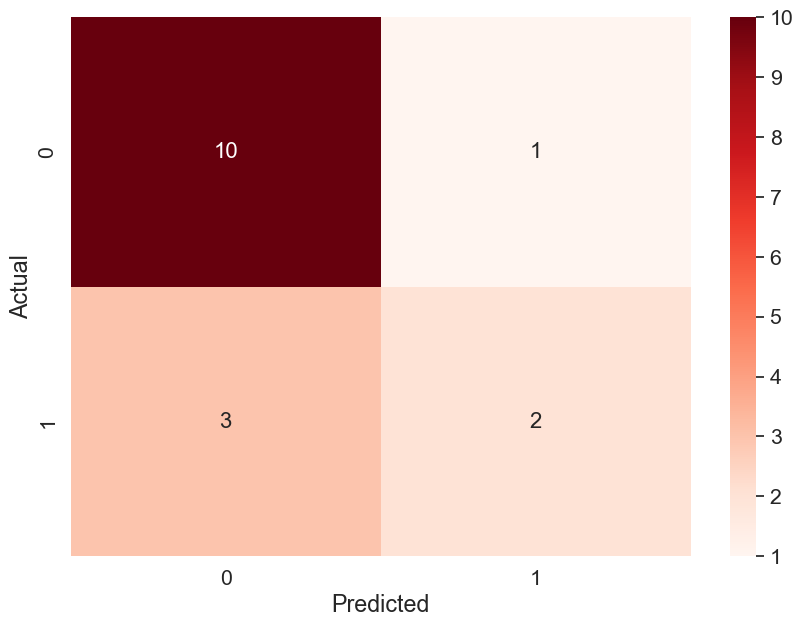

In [49]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [52]:
# What are the most important features?
feature_list = df.columns
feature_list = feature_list.drop(['frailty'])

imp_features = pd.Series(rfc.feature_importances_, index=feature_list)

imp_genes = imp_features.sort_values(ascending=False).to_frame().reset_index()
imp_genes.columns = ["features", "importance"]

imp_genes_fil = imp_genes[~(imp_genes == 0.000000).any(axis=1)]
imp_genes_fil

,features,importance
0,KCNJ16,0.041046
1,CFAP95,0.029707
2,SLPI,0.027397
3,ETNPPL,0.019607
4,SNORA72,0.019495
...,...,...
178,PNPLA3,0.000492
179,PCDHA3,0.000471
180,KLB,0.000372
181,WFDC21P,0.000080


In [53]:
df[imp_genes_fil['features']]

,KCNJ16,CFAP95,SLPI,ETNPPL,SNORA72,AREG,PDF,NME9,HOOK1,CIDEC,...,LRRC46,CP,CYP3A5,LINC01819,DANT2,PNPLA3,PCDHA3,KLB,WFDC21P,RBP4
0,20,1,22,5,0,7,16,27,1,269,...,2,18,3,0,0,3,4,106,0,200
1,1,1,17,26,5,7,26,10,1,63,...,2,8,0,1,0,3,1,6,0,25
2,10,2,8,11,3,12,9,34,7,73,...,1,12,2,0,0,9,0,11,0,36
3,26,4,62,0,1,15,33,25,7,14,...,0,4,3,1,0,6,0,1,0,19
4,8,2,23,14,4,16,6,3,1,6,...,0,9,0,0,0,0,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0,8,2,13,0,0,1,7,1,2,...,0,1,0,2,1,0,0,0,0,0
76,0,1,2,67,2,1,0,3,0,2,...,3,0,1,1,3,2,0,1,1,0
77,8,2,5,8,1,4,0,16,0,2,...,1,1,0,0,2,1,0,0,0,8
78,6,9,6,16,0,2,5,2,8,2,...,0,5,2,2,0,1,0,0,0,5


<Axes: xlabel='0', ylabel='1'>

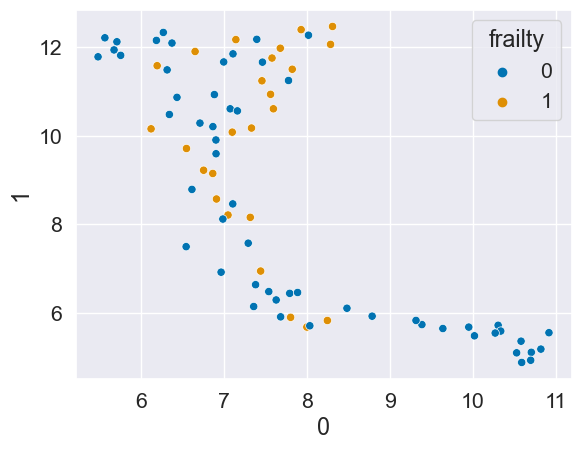

In [55]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[imp_genes_fil['features']])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.frailty, palette="colorblind")

## Baseline Linear Regression Model

In [70]:
# Instantiate the Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
lor = LogisticRegression(max_iter=1200)

# Fit the classifier to data
lor.fit(X_train, y_train)

# Predict on test dataset
y_pred = lor.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(lor.predict_proba(X_test))
print(y_test)

Accuracy: 0.6875
[[1.69621267e-01 8.30378733e-01]
 [7.53125816e-01 2.46874184e-01]
 [9.99116278e-01 8.83722420e-04]
 [9.99999999e-01 5.73184555e-10]
 [1.60598313e-02 9.83940169e-01]
 [9.99999712e-01 2.88062571e-07]
 [9.99962595e-01 3.74045398e-05]
 [9.99999993e-01 7.11627748e-09]
 [9.99999946e-01 5.39337382e-08]
 [3.42702146e-01 6.57297854e-01]
 [9.98292577e-01 1.70742348e-03]
 [9.99999962e-01 3.82109092e-08]
 [9.97630191e-01 2.36980912e-03]
 [2.79828713e-03 9.97201713e-01]
 [9.99999992e-01 7.76248285e-09]
 [9.99999050e-01 9.50295003e-07]]
[0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0]


<Axes: xlabel='Predicted', ylabel='Actual'>

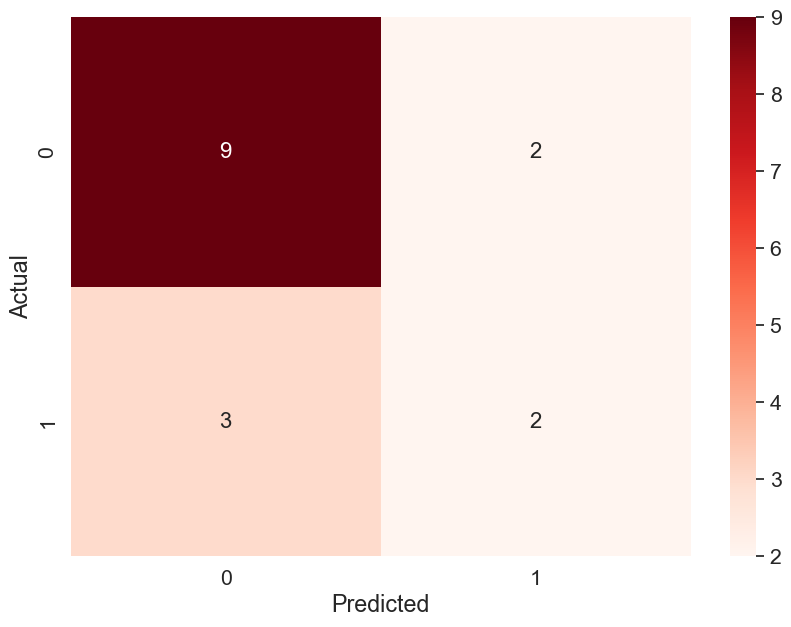

In [71]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [61]:
# Instantiate the Random Forest Classifier
lr = LinearRegression()

# Fit the classifier to data
lr.fit(X_train, y_train)

# Predict on test dataset
y_pred = lr.predict(X_test)

# Accuracy of model
#print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
#print(lr.predict_proba(X_test))
#print(y_test)

In [62]:
y_pred

array([ 0.5603194 ,  0.85639636, -0.27531019, -0.15027877,  1.17524065,
        0.62244361, -0.55611492,  0.20013326, -0.38428622,  0.36090142,
        0.8366651 , -0.06497032,  0.16110748,  0.78994853, -0.24429179,
        0.27951624])

In [72]:
lr.coef_

array([-1.08244129e-04,  2.79015594e-03,  6.69635937e-03,  2.36653737e-03,
        3.42120928e-03, -1.48501677e-03, -1.95599728e-03,  2.28759565e-03,
        2.52989732e-03,  4.44534079e-03,  3.03202556e-03,  3.12220110e-03,
        1.75318887e-03, -3.75610173e-03,  8.00951695e-04, -7.57997968e-04,
        1.63454481e-03,  7.42431563e-03,  1.91346335e-03,  1.77226583e-03,
        1.32133251e-03,  9.42919039e-04,  4.18022670e-03,  1.01469083e-02,
        1.02888381e-02,  2.94572761e-03,  7.62932716e-04,  4.86909536e-04,
        9.47384891e-03,  3.05797787e-03,  1.49498411e-03,  9.74269025e-04,
       -1.67448937e-03,  3.95312010e-03,  2.91186456e-03,  6.16117427e-03,
       -3.40153099e-04,  2.19642733e-03, -1.33732695e-04,  5.62730203e-05,
        3.89199158e-03, -4.98383420e-05, -1.88900046e-03,  1.19725065e-02,
        3.79854498e-04,  2.42450902e-03,  2.32377394e-04, -4.92941652e-04,
        2.07779229e-03,  2.35431255e-03,  1.99492785e-03, -1.31118166e-03,
       -3.19451946e-04,  

---

## Random Forest (CV)

In [56]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
lst_accu_stratified = []

rfc = RandomForestClassifier(max_depth=3, random_state=123)

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rfc.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(rfc.score(x_test_fold, y_test_fold))
  
# Print the output
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

KeyError: "None of [Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18,\n            19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,\n            37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55,\n            56, 57, 58, 59, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,\n            75, 76, 77, 79],\n           dtype='int64')] are in the [columns]"

---

## Logistic Regression Model (CV)

In [12]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
lst_accu_stratified = []

lr = LogisticRegression(max_iter=500, random_state=123)

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    lr.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))
  
# Print the output
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.625, 0.625, 0.375, 0.5, 0.625, 0.5, 0.5, 0.625, 0.625, 0.625]

Maximum Accuracy That can be obtained from this model is: 62.5 %

Minimum Accuracy: 37.5 %

Overall Accuracy: 56.25 %

Standard Deviation is: 0.08838834764831845


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

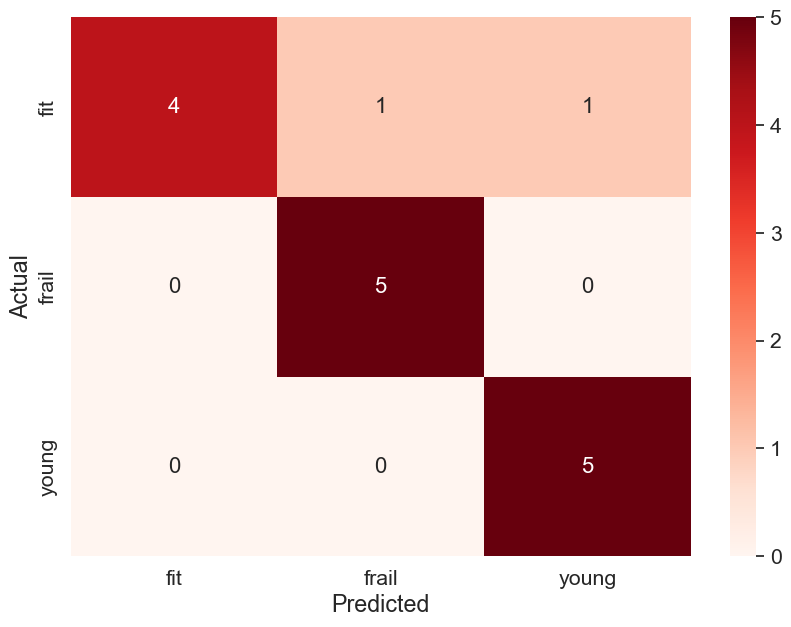

In [13]:
# Build confusion matrix
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [13]:
# What are the most important features?
feature_list = df.columns
feature_list = feature_list.drop(['sample_name', 'gender', 'treatment'])

imp_features = pd.Series(lr.coef_[0], index=feature_list)

imp_genes = imp_features.sort_values(ascending=False).to_frame().reset_index()
imp_genes.columns = ["features", "importance"]

imp_genes_fil = imp_genes[~(imp_genes == 0.000000).any(axis=1)]
imp_genes_fil

,features,importance
0,COX3,0.000496
1,CKM,0.000441
2,MYBPC1,0.000373
3,ND2,0.000360
4,TNNT1,0.000308
...,...,...
35830,ND4,-0.000287
35831,ND1,-0.000310
35832,ATP2A2,-0.000348
35833,CYTB,-0.000353


<Axes: xlabel='0', ylabel='1'>

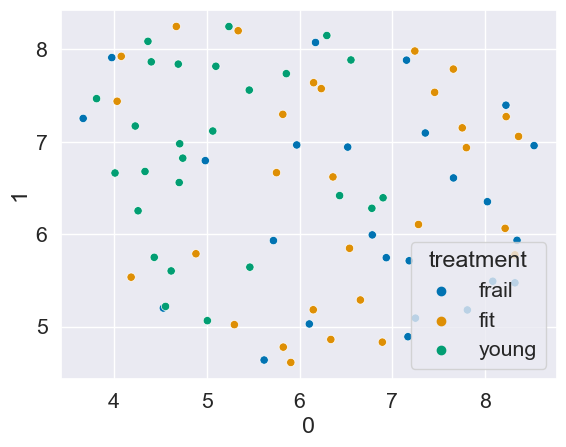

In [14]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[imp_genes_fil['features']])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

---

## Feature Selection

In [15]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=500000)
selector.fit(df.iloc[:,3:])
X_ = df.iloc[:,3:].iloc[:,selector.get_support()]
X_

,SLC7A2,POLDIP2,HSPB6,PDK4,PDK2,PHTF2,SCN4A,NFIX,RPS20,CSDE1,...,NEAT1,OIP5-AS1,MTATP6P1,C4orf54,ACTN3,MALAT1,NORAD,DYNLL2,MIR133A1HG,TXNIP
0,3211,2334,12829,11584,2408,2268,4626,4873,2967,27417,...,9541,2398,23866,2255,8880,112476,4361,3526,2216,22220
1,2449,2978,11777,6236,3661,1292,3007,3158,3034,31109,...,11258,3110,33103,1237,3686,132066,3756,4443,2059,13459
2,3507,2799,13621,4446,2599,1914,4246,3934,2341,26920,...,14472,2915,24687,3166,11128,105400,3613,3561,3046,8509
3,4350,3163,7067,4118,3208,1950,5302,3554,3504,30190,...,12878,3035,28796,2713,14111,142029,4465,3683,2515,15215
4,2556,3087,8527,14603,3426,1779,3134,2744,3379,30879,...,11347,3056,20878,2107,216,156032,3467,4160,2045,8729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2793,2406,7584,2178,2547,2127,3360,3989,2093,30237,...,8034,2859,27299,3193,3750,110913,4058,2888,2073,12383
76,2339,2487,5802,9318,2291,2108,3298,3982,1843,30243,...,4699,4934,41023,2326,5151,67401,3483,3301,1750,13109
77,3185,2256,6074,11641,2304,1803,3404,3137,2892,31321,...,12549,2998,18842,1510,10257,116049,3797,3218,2880,10891
78,3553,2344,7421,6137,2949,1490,3266,3311,2348,25914,...,9939,3331,22033,1481,3506,89678,2852,2556,4823,8792


<Axes: xlabel='0', ylabel='1'>

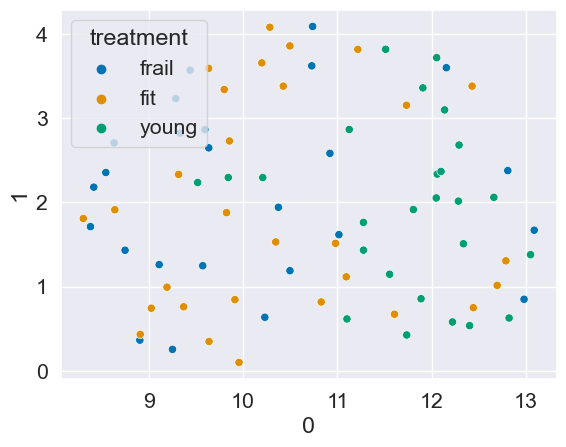

In [16]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X_)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

---

## Recursive Feature Elimination (100 genes)

In [17]:
from sklearn.feature_selection  import RFE

model = RandomForestClassifier(max_depth=3, random_state=123)
rfe = RFE(model, n_features_to_select=100)
rfe.fit(X, y)
y_pred = rfe.predict(X)

In [18]:
#rfe.support_
rfe.ranking_

array([35736, 35735, 35734, ..., 30112, 30804, 31213])

In [77]:
rfe_X = df.iloc[:,3:].iloc[:,rfe.support_]
rfe_X

,RNF115,MIR3156-2,MIR1269B,MIR4435-1,MIR4436A,LINC01892,MIR548V,MIR5697,MIR4304,MIR5690,...,GGNBP2,ZNF229,LOC101929140,DHRS11,ACACA,MRPL45,LOC645967,HEIH,EBLN3P,LOC101929130
0,1707,0,0,0,0,0,0,0,0,2,...,498,23,8,98,171,395,9,83,286,43
1,1546,0,0,0,0,0,0,3,0,1,...,519,15,13,144,133,428,5,104,267,6
2,1616,0,0,0,0,0,0,0,0,8,...,482,28,8,127,132,367,9,78,262,33
3,1697,0,0,0,0,0,0,2,0,3,...,655,23,9,120,169,402,3,108,344,25
4,2187,0,0,0,0,0,0,1,0,0,...,464,21,7,113,169,413,6,84,275,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1482,0,0,0,0,0,0,1,0,4,...,357,20,4,82,117,373,12,50,273,53
76,1566,0,0,0,0,0,0,3,0,4,...,328,19,5,121,141,396,8,63,300,30
77,2252,0,0,0,0,0,0,0,0,3,...,340,20,6,86,119,347,10,71,192,3
78,1797,0,0,0,0,0,0,4,0,7,...,404,45,4,141,152,388,5,86,179,2


In [ ]:
rfe_X.columns

<AxesSubplot:xlabel='0', ylabel='1'>

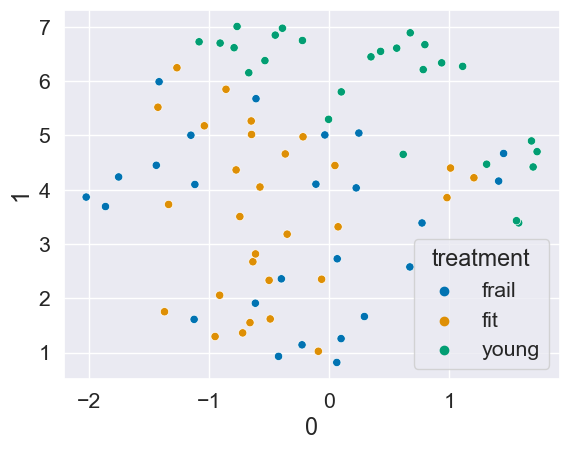

In [73]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.iloc[:,3:].iloc[:,rfe.support_])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

In [94]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(rfe_X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

# Instantiate the Random Forest Classifier
rfc = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the classifier to data
rfc.fit(X_train, y_train)

# Predict on test dataset
y_pred = rfc.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(rfc.predict_proba(X_test))

Accuracy: 0.8125
[[0.54780149 0.3536411  0.09855741]
 [0.33193006 0.03566235 0.63240759]
 [0.4763365  0.43676357 0.08689993]
 [0.52137659 0.2855229  0.19310051]
 [0.18982638 0.10149372 0.7086799 ]
 [0.63187483 0.32727276 0.0408524 ]
 [0.15807758 0.12545292 0.7164695 ]
 [0.42045059 0.47430192 0.10524749]
 [0.4287354  0.35600303 0.21526157]
 [0.39530916 0.31448233 0.29020851]
 [0.23977854 0.24976816 0.51045331]
 [0.47591393 0.25380855 0.27027752]
 [0.38638796 0.49934755 0.11426449]
 [0.22924086 0.12921051 0.64154863]
 [0.51512572 0.34396877 0.14090551]
 [0.48996951 0.29014122 0.21988927]]


---

## Recursive Feature Elimination (20 genes)

In [86]:
from sklearn.feature_selection  import RFE

model = RandomForestClassifier(max_depth=3, random_state=123)
rfe_20 = RFE(model, n_features_to_select=20)
rfe_20.fit(X, y)
y_pred_20 = rfe.predict(X)

In [87]:
rfe20_X = df.iloc[:,3:].iloc[:,rfe_20.support_]
rfe20_X

,RNF115,STRADA,NCOA4,FXYD1,ILF3-DT,ZNF285,MAGIX,TMEM185A,EGLN2,CAHM,TAF15,KMT2B,POM121C,ATP6V1FNB,PAXIP1-DT,ZNHIT3,CCL14,GGNBP2,EBLN3P,LOC101929130
0,1707,48,2496,48,372,27,29,46,85,25,1109,370,163,10,83,325,17,498,286,43
1,1546,54,3562,50,470,18,21,73,70,22,1048,249,120,17,79,359,2,519,267,6
2,1616,44,2576,30,474,32,50,48,44,28,931,293,121,11,122,276,2,482,262,33
3,1697,65,2929,46,539,24,45,50,91,17,1236,371,159,27,76,356,2,655,344,25
4,2187,58,3281,55,561,17,37,53,67,20,1164,259,168,23,57,333,3,464,275,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1482,46,2256,31,352,30,22,44,35,20,894,218,117,2,57,289,0,357,273,53
76,1566,36,2965,21,316,26,15,57,44,12,776,216,90,4,43,196,3,328,300,30
77,2252,52,2043,52,412,26,19,39,49,11,1003,224,93,12,74,245,16,340,192,3
78,1797,48,2614,19,367,39,8,41,52,15,994,339,124,27,67,243,7,404,179,2


In [1]:
rfe_20_X.columns

NameError: name 'rfe_20_X' is not defined

<AxesSubplot:xlabel='0', ylabel='1'>

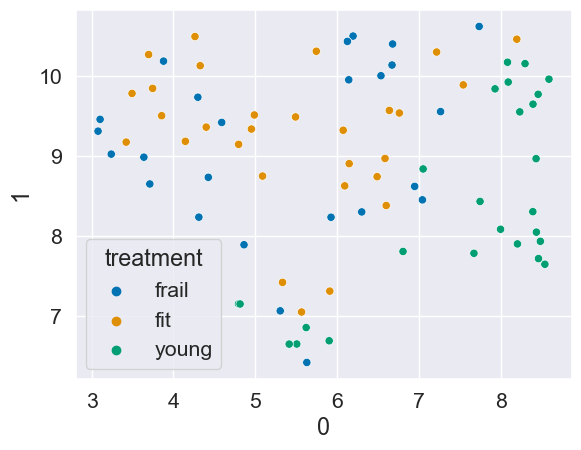

In [88]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(rfe20_X)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

In [93]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(rfe20_X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

# Instantiate the Random Forest Classifier
rfc = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the classifier to data
rfc.fit(X_train, y_train)

# Predict on test dataset
y_pred = rfc.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(rfc.predict_proba(X_test))

Accuracy: 0.875
[[0.56858987 0.3686362  0.06277393]
 [0.25892308 0.07631125 0.66476568]
 [0.52622659 0.37370518 0.10006823]
 [0.6473961  0.1941037  0.1585002 ]
 [0.12943252 0.12861983 0.74194765]
 [0.6986999  0.25412291 0.04717719]
 [0.10692935 0.07291832 0.82015232]
 [0.4088971  0.54286451 0.04823839]
 [0.3631357  0.4610102  0.1758541 ]
 [0.57771767 0.21689102 0.20539131]
 [0.24766976 0.21262364 0.53970661]
 [0.53701214 0.2547235  0.20826436]
 [0.38230923 0.51316832 0.10452245]
 [0.21996679 0.05880275 0.72123046]
 [0.47961674 0.39499514 0.12538812]
 [0.49924355 0.30288852 0.19786793]]


---

## Recursive Feature Elimination (10 genes)

In [96]:
from sklearn.feature_selection  import RFE

model = RandomForestClassifier(max_depth=3, random_state=123)
rfe_10 = RFE(model, n_features_to_select=10)
rfe_10.fit(rfe20_X, y)
y_pred_10 = rfe_10.predict(rfe20_X)

In [101]:
rfe10_X = rfe20_X.iloc[:,rfe_10.support_]
rfe10_X

,RNF115,STRADA,CAHM,TAF15,KMT2B,POM121C,ATP6V1FNB,PAXIP1-DT,CCL14,GGNBP2
0,1707,48,25,1109,370,163,10,83,17,498
1,1546,54,22,1048,249,120,17,79,2,519
2,1616,44,28,931,293,121,11,122,2,482
3,1697,65,17,1236,371,159,27,76,2,655
4,2187,58,20,1164,259,168,23,57,3,464
...,...,...,...,...,...,...,...,...,...,...
75,1482,46,20,894,218,117,2,57,0,357
76,1566,36,12,776,216,90,4,43,3,328
77,2252,52,11,1003,224,93,12,74,16,340
78,1797,48,15,994,339,124,27,67,7,404


<AxesSubplot:xlabel='0', ylabel='1'>

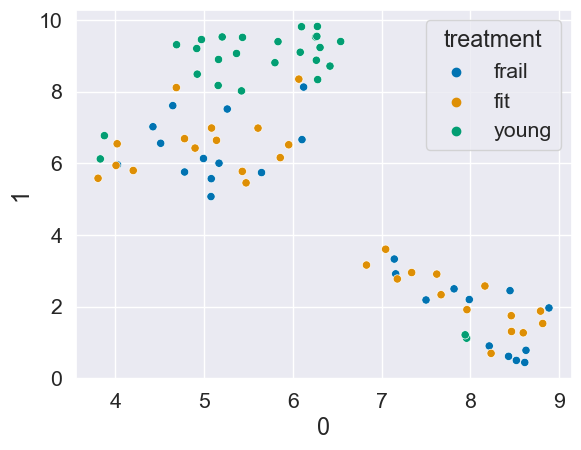

In [103]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(rfe10_X)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

In [102]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(rfe10_X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

# Instantiate the Random Forest Classifier
rfc = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the classifier to data
rfc.fit(X_train, y_train)

# Predict on test dataset
y_pred = rfc.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(rfc.predict_proba(X_test))

Accuracy: 0.875
[[0.53240978 0.42491939 0.04267083]
 [0.19013708 0.12705493 0.68280799]
 [0.60514664 0.32807731 0.06677605]
 [0.42117291 0.32739352 0.25143357]
 [0.10575405 0.07993357 0.81431238]
 [0.612872   0.33655065 0.05057735]
 [0.19051774 0.08020158 0.72928068]
 [0.50898862 0.44236439 0.048647  ]
 [0.24053463 0.68094036 0.07852501]
 [0.59787201 0.19901765 0.20311034]
 [0.31470842 0.19509955 0.49019203]
 [0.48479674 0.4343873  0.08081595]
 [0.43382934 0.52981268 0.03635798]
 [0.0943141  0.0642765  0.84140939]
 [0.50064023 0.45735324 0.04200653]
 [0.37653057 0.43787178 0.18559765]]


---

## LASSO Regularization (L1)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Set the regularization parameter C=1
lr = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state=123)
lr.fit(X,y)
model = SelectFromModel(lr, prefit=True)

X_new = model.transform(X)

# Drop columns that have values of all 0s
#selected_columns = selected_features.columns[selected_features.var() != 0]


In [81]:
pd.DataFrame(X_new)

,0,1,2,3,4,5,6,7,8,9,...,880,881,882,883,884,885,886,887,888,889
0,3211,12829,11584,2408,2418,352,2268,1927,4873,922,...,1009,4361,3526,2216,1707,22220,1109,2685,908,236
1,2449,11777,6236,3661,2236,514,1292,1856,3158,1481,...,1050,3756,4443,2059,1546,13459,1048,2303,931,61
2,3507,13621,4446,2599,2220,332,1914,1661,3934,989,...,1016,3613,3561,3046,1616,8509,931,2376,787,310
3,4350,7067,4118,3208,3160,353,1950,2030,3554,1190,...,1144,4465,3683,2515,1697,15215,1236,2558,810,31
4,2556,8527,14603,3426,1684,508,1779,2136,2744,1100,...,860,3467,4160,2045,2187,8729,1164,2284,1435,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2793,7584,2178,2547,2244,238,2127,1857,3989,849,...,1083,4058,2888,2073,1482,12383,894,2021,1015,35
76,2339,5802,9318,2291,1767,294,2108,1438,3982,1028,...,1035,3483,3301,1750,1566,13109,776,2832,1231,98
77,3185,6074,11641,2304,1891,294,1803,1909,3137,786,...,756,3797,3218,2880,2252,10891,1003,2735,486,788
78,3553,7421,6137,2949,1486,431,1490,1884,3311,889,...,1041,2852,2556,4823,1797,8792,994,2656,634,597


In [85]:
df.iloc[:,3:].iloc[:,model.get_support()]


,SLC7A2,HSPB6,PDK4,PDK2,LAMP2,SPATA20,PHTF2,SYPL1,NFIX,ST3GAL1,...,ZNF710-AS1,NORAD,DYNLL2,MIR133A1HG,RNF115,TXNIP,TAF15,NUDT3,NATD1,FAM238C
0,3211,12829,11584,2408,2418,352,2268,1927,4873,922,...,1009,4361,3526,2216,1707,22220,1109,2685,908,236
1,2449,11777,6236,3661,2236,514,1292,1856,3158,1481,...,1050,3756,4443,2059,1546,13459,1048,2303,931,61
2,3507,13621,4446,2599,2220,332,1914,1661,3934,989,...,1016,3613,3561,3046,1616,8509,931,2376,787,310
3,4350,7067,4118,3208,3160,353,1950,2030,3554,1190,...,1144,4465,3683,2515,1697,15215,1236,2558,810,31
4,2556,8527,14603,3426,1684,508,1779,2136,2744,1100,...,860,3467,4160,2045,2187,8729,1164,2284,1435,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2793,7584,2178,2547,2244,238,2127,1857,3989,849,...,1083,4058,2888,2073,1482,12383,894,2021,1015,35
76,2339,5802,9318,2291,1767,294,2108,1438,3982,1028,...,1035,3483,3301,1750,1566,13109,776,2832,1231,98
77,3185,6074,11641,2304,1891,294,1803,1909,3137,786,...,756,3797,3218,2880,2252,10891,1003,2735,486,788
78,3553,7421,6137,2949,1486,431,1490,1884,3311,889,...,1041,2852,2556,4823,1797,8792,994,2656,634,597


<AxesSubplot:xlabel='0', ylabel='1'>

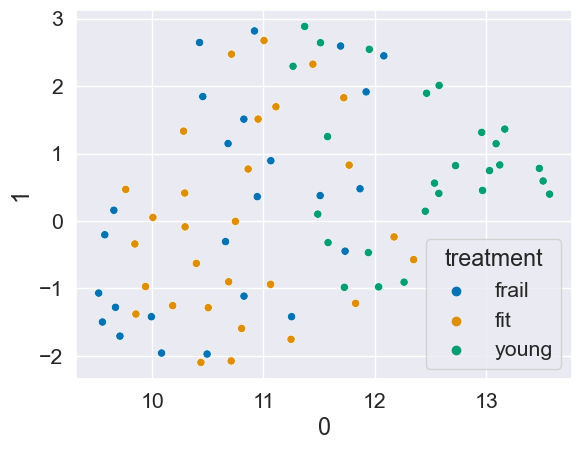

In [82]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X_new)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")